In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from autoencoder import AutoEncoder, VariationalAutoEncoder, RMS
import resources
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import PurePosixPath as Path
from tensorflow.keras.models import Model

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load in RMS data for tests

In [2]:
exps = ['Test 5', 'Test 7', 'Test 8', 'Test 9']
# exps = ['Test 5', 'Test 9']
rms = {}

for test in exps:
    rms[test] = resources.ae.RMS(test)
    rms[test].data.drop(['0', '1', '2',], axis=1, inplace=True)
    
try:
    rms['Test 5'].data.drop(['23', '24'], axis=1, inplace=True)
except KeyError:
    pass

--------------------------------------------------
Loaded RMS data for "22_08_03_grit1000"
Experiemnt No: Test 5
Number of files: 213
--------------------------------------------------
--------------------------------------------------
Loaded RMS data for "22_11_07_weartest_1000"
Experiemnt No: Test 7
Number of files: 163
--------------------------------------------------
--------------------------------------------------
Loaded RMS data for "22_11_09_weartest_1000"
Experiemnt No: Test 8
Number of files: 176
--------------------------------------------------
--------------------------------------------------
Loaded RMS data for "22_11_30_weartest_1000"
Experiemnt No: Test 9
Number of files: 158
--------------------------------------------------


# Setup Variational Autoencoder for each Test
- The model is trained over a small section of the test depending on `train_slice`.
- The model parameters are specified within the `params` dict.

In [3]:
autoe = {}
for test in exps:
        """
        autoe[test] = VariationalAutoEncoder(rms[test],
                                           tb=False,
                                           tb_logdir=rms[test].exp_name,
                                           train_slice=(0, 50),
                                           random_state=1,
                                           params={'latent_dim': 2,
                                                   'n_size': [32, 16],
                                                   'epochs': 300,
                                                   'batch_size': 20,
                                                   'callbacks': [
                                                           tf.keras.callbacks.EarlyStopping(
                                                                monitor='val_loss',
                                                                patience=30,
                                                                mode='min',
                                                                start_from_epoch=100,
                                                           ),
                                                        ]
                                                   }
                                           )
        """
        autoe[test] = AutoEncoder(rms[test],
                                  tb=False,
                                  tb_logdir=rms[test].exp_name.upper().replace(' ', '_'),
                                  train_slice=(0, 75),
                                  val_frac=0.33,
                                  random_state=2,
                                  params={'n_bottleneck': 4,
                                          'n_size': [64, 64],
                                          'epochs': 750,
                                          'batch_size': 40,
                                          'loss': 'mse',
                                          'callbacks': [
                                                  tf.keras.callbacks.EarlyStopping(
                                                              monitor='val_loss',
                                                              patience=80,
                                                              mode='min',
                                                              start_from_epoch= 150,
                                                  ),
                                                #   tf.keras.callbacks.ReduceLROnPlateau(
                                                #                 monitor='val_loss',
                                                #                 mode='min',
                                                #                 patience=25,
                                                #                 factor=0.01,
                                                #   ),
                                                ]

                                          }
                                  )       

Pre-Processing Data:
	Training Data: slice(0, 75, None)
	Input train shape: (50, 407)
	Input val shape: (25, 407)

AUTOE-Test_5-E-750-L-[64, 64, 4, 64, 64]-20230612-150415

Pre-Processing Data:
	Training Data: slice(0, 75, None)
	Input train shape: (50, 410)
	Input val shape: (25, 410)

AUTOE-Test_7-E-750-L-[64, 64, 4, 64, 64]-20230612-150415

Pre-Processing Data:
	Training Data: slice(0, 75, None)
	Input train shape: (50, 393)
	Input val shape: (25, 393)

AUTOE-Test_8-E-750-L-[64, 64, 4, 64, 64]-20230612-150415

Pre-Processing Data:
	Training Data: slice(0, 75, None)
	Input train shape: (50, 394)
	Input val shape: (25, 394)

AUTOE-Test_9-E-750-L-[64, 64, 4, 64, 64]-20230612-150415



In [4]:
platform = os.name
if platform == 'nt':
    onedrive = Path(r'C:\Users\tomje\OneDrive - Cardiff University')
    onedrive = onedrive.joinpath('Documents', 'PHD', 'AE')
    TB_DIR= onedrive.joinpath('Tensorboard')
elif platform == 'posix':
    onedrive = Path(r'/mnt/c/Users/tomje/OneDrive - Cardiff University')
    onedrive = onedrive.joinpath('Documents', 'PHD', 'AE')
    TB_DIR= onedrive.joinpath('Tensorboard')
print(TB_DIR)

/mnt/c/Users/tomje/OneDrive - Cardiff University/Documents/PHD/AE/Tensorboard


In [5]:
# add model checkpoint callback after creating model
for test in exps:
    name = autoe[test].run_name
    model_folder = TB_DIR.joinpath(autoe[test]._tb_logdir.joinpath(name))
    if not os.path.exists(model_folder):
       os.makedirs(model_folder)
    assert os.path.exists(model_folder)

    autoe[test].model.callbacks.append(
        tf.keras.callbacks.ModelCheckpoint(
        filepath=model_folder.joinpath(f'{name}.h5'),
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_weights_only=True,
        )
    )

# Train each autoe on the training data
- `x` is the inputted data for training, which is `autoe.train_data`
- `val_data` is the validation data from `autoe.val_data`

In [6]:
for test in exps:
        autoe[test].fit(x=autoe[test].train_data,
                      val_data=autoe[test].val_data,
                      verbose=0,
                      use_multiprocessing=True,
                      )

Training:   0%|           0/750 ETA: ?s,  ?epochs/s

Training:   0%|           0/750 ETA: ?s,  ?epochs/s

Training:   0%|           0/750 ETA: ?s,  ?epochs/s

Training:   0%|           0/750 ETA: ?s,  ?epochs/s

## Reload saved weights from best model

In [7]:
for test in exps:
    name = autoe[test].run_name
    model_folder = TB_DIR.joinpath(autoe[test]._tb_logdir.joinpath(name))
    autoe[test].model.model_.load_weights(
        TB_DIR.joinpath(model_folder.joinpath(f'{name}.h5'),),
    )
    autoe[test].pred = None
    autoe[test].scores = None

# Results Visualisation

## Loss plot of each trained model

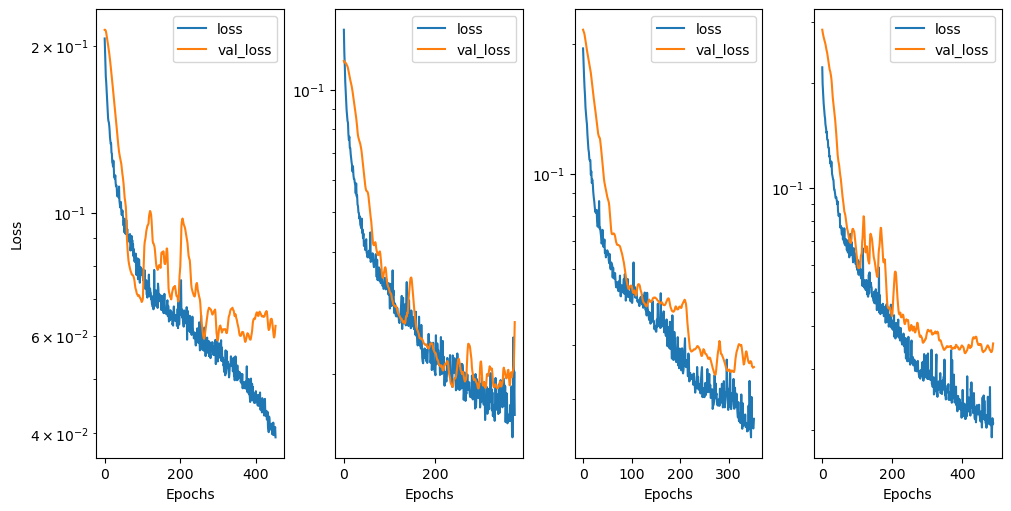

In [8]:
fig, ax = plt.subplots(1, len(exps),
                       figsize=(10,5),
                       constrained_layout=True,
                       )
# ax = ax.ravel()
for i, test in enumerate(exps):
    axis = fig.axes[i]
    autoe[test].loss_plot(plt_ax=axis)
    axis.set_yscale('log')
    if i > 0:
        axis.set_ylabel('')

## Score each model
- Models scored on train, validation and whole dataset

In [9]:
for test in exps:
    print(f'\n {test}')
    pred_tr, scores_tr = autoe[test].score('train')
    pred_val, scores_val = autoe[test].score('val')
    pred_data, scores_data = autoe[test].score('dataset')


 Test 5

Train Scores:
	MAE: 0.17666
	MSE: 0.05203
	R2: 0.05491

Val Scores:
	MAE: 0.18585
	MSE: 0.05845
	R2: 0.00310

Dataset Scores:
	MAE: 0.44020
	MSE: 0.44588
	R2: -0.79878

 Test 7

Train Scores:
	MAE: 0.09582
	MSE: 0.01615
	R2: 0.29153

Val Scores:
	MAE: 0.10407
	MSE: 0.01843
	R2: 0.27858

Dataset Scores:
	MAE: 0.14738
	MSE: 0.04198
	R2: -0.03299

 Test 8

Train Scores:
	MAE: 0.12959
	MSE: 0.02957
	R2: 0.26673

Val Scores:
	MAE: 0.14002
	MSE: 0.03419
	R2: 0.23295

Dataset Scores:
	MAE: 0.20972
	MSE: 0.19682
	R2: 0.13095

 Test 9

Train Scores:
	MAE: 0.11523
	MSE: 0.02240
	R2: 0.39289

Val Scores:
	MAE: 0.14169
	MSE: 0.03331
	R2: 0.11185

Dataset Scores:
	MAE: 0.25953
	MSE: 0.19585
	R2: -0.15592


## Show histogram of scores across whole dataset

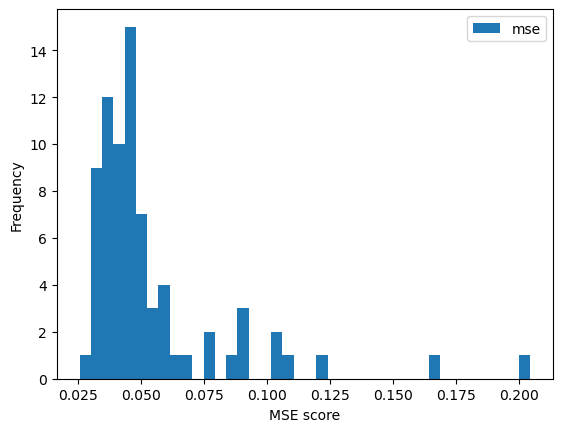

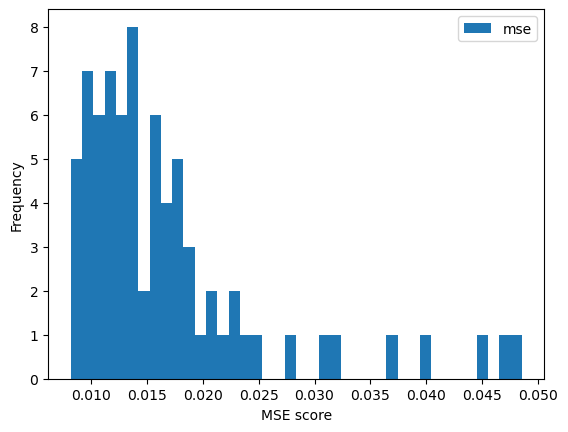

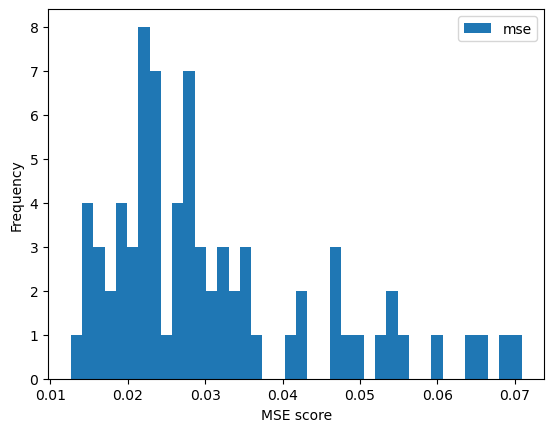

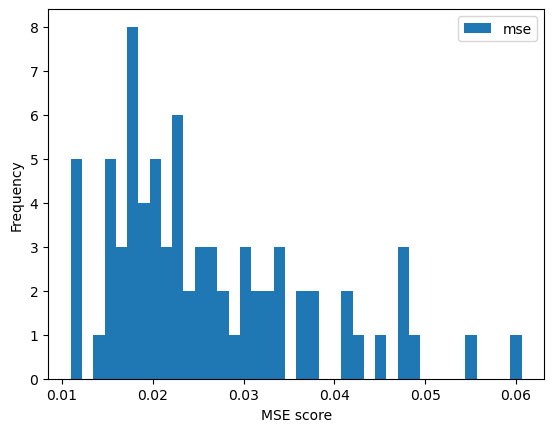

In [10]:
for test in exps:
    fig, ax = autoe[test].hist_scores(['mse'])

## Show model recreation capability of training and validation sets

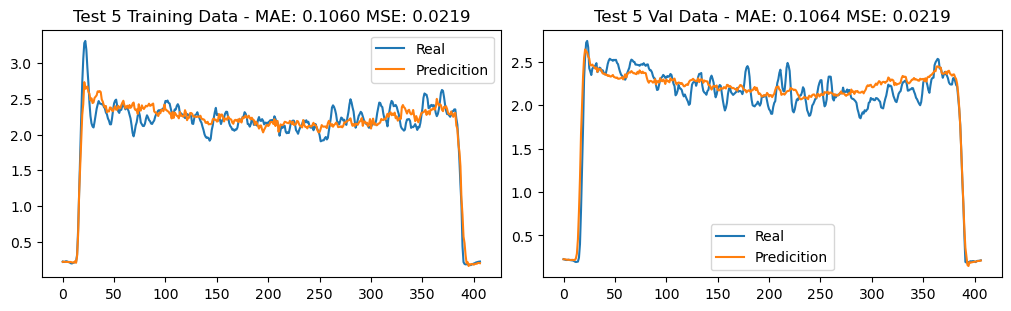

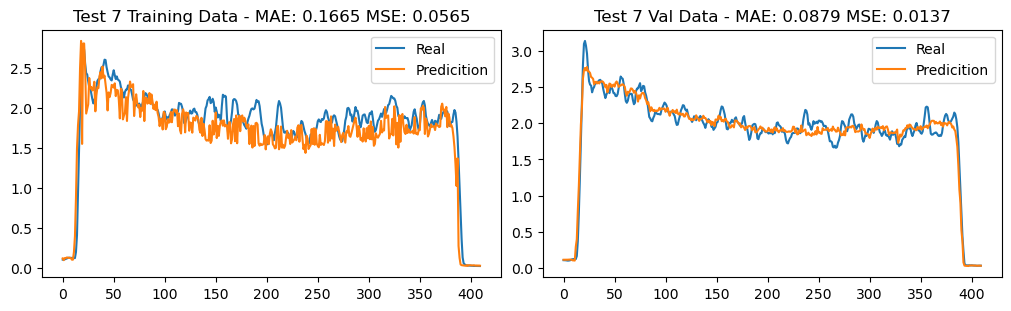

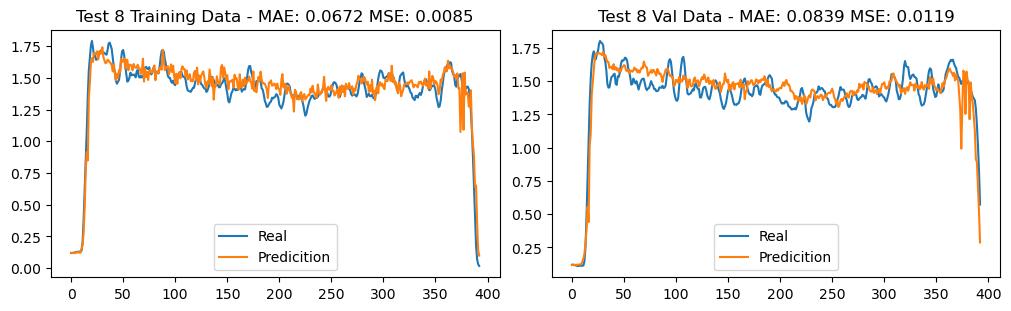

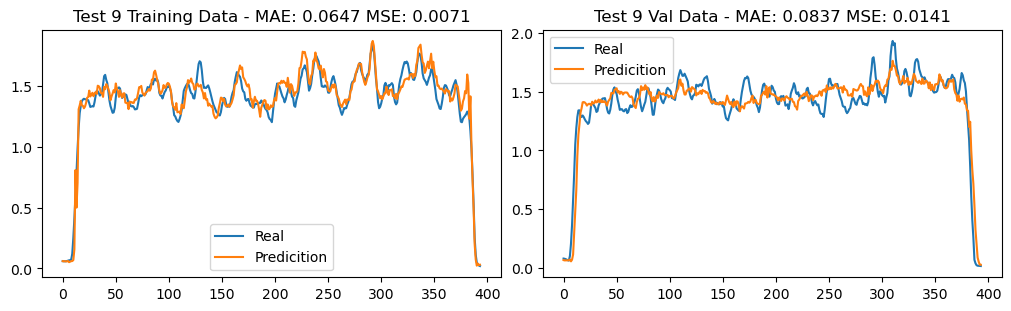

In [11]:
for test in exps:
    fig, ax = plt.subplots(1, 2, figsize=(10,3), constrained_layout=True)
    ax = ax.ravel()

    # Training plot
    ax[0] = autoe[test].pred_plot(autoe[test]._ind_tr[0], plt_ax=ax[0])
    ax[0].set_title(f'{autoe[test].RMS.exp_name} Training Data - {ax[0].get_title()}')

    # Validation plot
    ax[1] = autoe[test].pred_plot(autoe[test]._ind_val[0], plt_ax=ax[1])
    ax[1].set_title(f'{autoe[test].RMS.exp_name} Val Data - {ax[1].get_title()}')

## Thresholds for anomaly detection of each model

In [12]:
for test in exps:
    autoe[test].thres


Cutoffs:
	MAE cutoff: 0.22277
	MSE cutoff: 0.08375
	R2 cutoff: -0.35875

Cutoffs:
	MAE cutoff: 0.12172
	MSE cutoff: 0.02565
	R2 cutoff: -0.11147

Cutoffs:
	MAE cutoff: 0.16088
	MSE cutoff: 0.04518
	R2 cutoff: -0.00867

Cutoffs:
	MAE cutoff: 0.14974
	MSE cutoff: 0.03698
	R2 cutoff: 0.00640


## Show scores against threshold

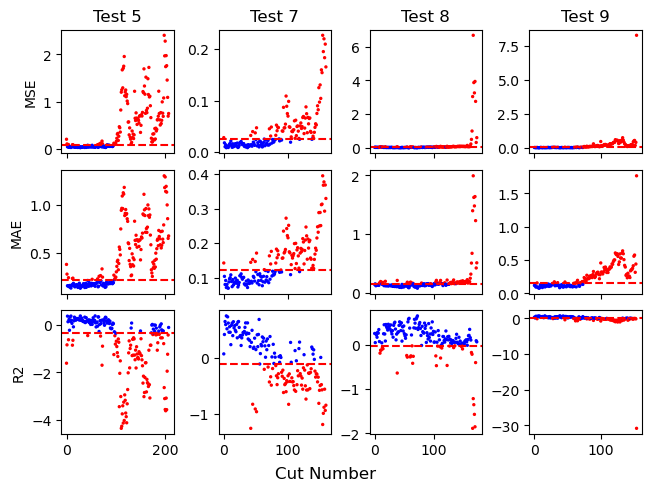

In [13]:
metrics = ['mse', 'mae', 'r2']

fig, ax = plt.subplots(len(metrics), len(exps),
                    #    figsize=(15, 5),
                       constrained_layout=True,
                    #    sharey= 'row',
                       sharex='col',
                       )
axes = fig.axes

for i, test in enumerate(exps):
    for j, met in enumerate(metrics):
        _ = autoe[test].scatter_scores([met], plt_ax=axes[(i + (j * len(exps)))])

        axes[(i)].set_title(test)
        axes[(len(exps) * j) + i].set_ylabel('')
        axes[(len(exps) * j) + i].set_xlabel('')
        if i == 0:
            axes[(len(exps) * j) + i].set_ylabel(f'{met.upper()}')

_ = fig.supxlabel('Cut Number')

In [14]:
dfs = [pd.DataFrame(autoe[test].scores) for test in exps]
df = pd.concat(dfs, keys=exps, names=['Test', 'Metrics'])
for test in exps:
    print(f'\n {test}')
    print(df.loc[test].describe())


 Test 5
              mae         mse          r2
count  208.000000  208.000000  208.000000
mean     0.440200    0.445880   -0.798780
std      0.312730    0.533159    1.222450
min      0.131724    0.025524   -4.344867
25%      0.177750    0.048599   -1.294547
50%      0.313391    0.163244   -0.281109
75%      0.646179    0.693969    0.134727
max      1.305095    2.403900    0.370944

 Test 7
              mae         mse          r2
count  160.000000  160.000000  160.000000
mean     0.147377    0.041983   -0.032991
std      0.069024    0.042670    0.464286
min      0.069213    0.008205   -1.267038
25%      0.093136    0.015229   -0.376889
50%      0.123474    0.025234    0.013308
75%      0.178887    0.049413    0.369095
max      0.395495    0.227366    0.760610

 Test 8
              mae         mse          r2
count  173.000000  173.000000  173.000000
mean     0.209718    0.196824    0.130947
std      0.269424    0.754382    0.378719
min      0.082417    0.012611   -1.883516
25%    

## autoe models latent space

In [15]:
# for test in exps:
#     fig, ax = autoe[test].plot_latent_space()

## Wear measurements comparison

/tmp/ipykernel_14449/1395292657.py:62: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


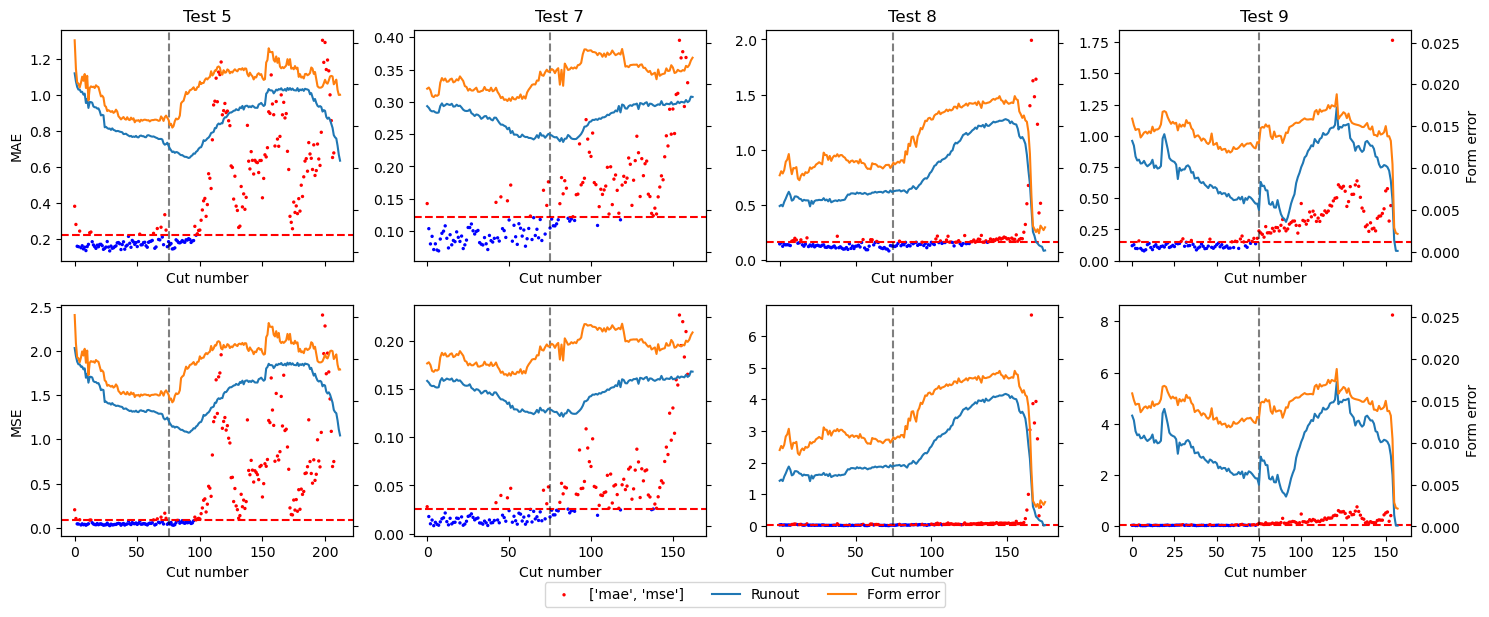

In [16]:
features = ['Runout', 'Form error']
metric = ['mae', 'mse']


fig, ax = plt.subplots(len(metric), len(exps),
                       figsize=(15, 6),
                       constrained_layout=True,
                    #    sharey= 'row',
                       sharex='col',
                       )

ax2 = []
for a in ax.ravel():
    ax2.append(a.twinx())

for a, b in zip(ax2[1:], ax2[0:-1]):
    a.sharey(b)

ax2 = np.reshape(ax2, ax.shape)

axes = fig.axes
axes2 = axes[-(len(axes) // 2):]
axes = axes[0:(len(axes) // 2)]
for i, test in enumerate(exps):
    axes[i].set_title(test)

    exp = resources.load(test)
    for j, met in enumerate(metric):
        _ = autoe[test].scatter_scores([met], plt_ax=axes[(i + (j * len(exps)))])

        # vert line to show where training data ends
        axes[(len(exps) * j) + i].axvline(autoe[test]._train_slice.stop,
                                    color='k',
                                    linestyle='--',
                                    alpha=0.5,
                                    )

        for feature in features:
            feat = exp.features[feature]
            axes2[(len(exps) * j) + i].plot(range(len(feat)), feat, label=feature)

        axes[(len(exps) * j) + i].set_ylabel('')
        if i == 0:
            axes[(len(exps) * j) + i].set_ylabel(f'{met.upper()}')
        if i ==len(exps) - 1:
            axes2[(len(exps) * j) + i].set_ylabel(f'{feature}')


for i, a in enumerate(axes2):
    if (i + 1) % len(exps) != 0:
        plt.setp(a.get_yticklabels(), visible=False)

l1, lab1 = axes[0].get_legend_handles_labels()
l2, lab2 = axes2[0].get_legend_handles_labels()

plt.figlegend(l1 + l2,
              [metric] + lab2, 
              loc='center', 
              bbox_to_anchor=(0.5, 0),
              ncol=len(l1 + l2)
              )
plt.tight_layout()

# LSTM with Encoded Input

## Encode Inputs

In [17]:
encoders = {}
for test in exps:
    ae = autoe[test].model.model_
    encoders[test] = Model(inputs=ae.get_layer('Encoder').input, outputs=ae.get_layer('Encoder').output)

In [18]:
encoded_inputs = {}
for test in exps:
    inp = rms[test].data.values
    inp = autoe[test].scaler.transform(inp.T)
    encoded_inputs[test] = encoders[test].predict(inp, verbose=0)

In [19]:
TARGET = 'Runout'

encoded_main_dfs = {}
for test in exps:
    exp = resources.load(test)
    target = exp.features[TARGET]
    if exp.test_info.testno == 5:
        target = target.drop([23, 24], axis=0)
    target = target.drop([0, 1, 2], axis=0).values
    inputs = np.concatenate([encoded_inputs[test], target.reshape(-1, 1)], axis=1)
    encoded_main_dfs[test] = pd.DataFrame(inputs, columns=['L1', 'L2', 'L3', 'L4', 'Target'])
    print(encoded_main_dfs[test].shape)

(208, 5)
(160, 5)
(173, 5)
(155, 5)


In [20]:
from sklearn.preprocessing import MinMaxScaler

for test in exps:
    scaler = MinMaxScaler()
    y = scaler.fit_transform(encoded_main_dfs[test]['Target'].values.reshape(-1, 1))
    encoded_main_dfs[test]['Target'] = y

In [21]:
joined_df = pd.concat(encoded_main_dfs.values())
joined_df.reset_index(drop=True, inplace=True)

<Axes: >

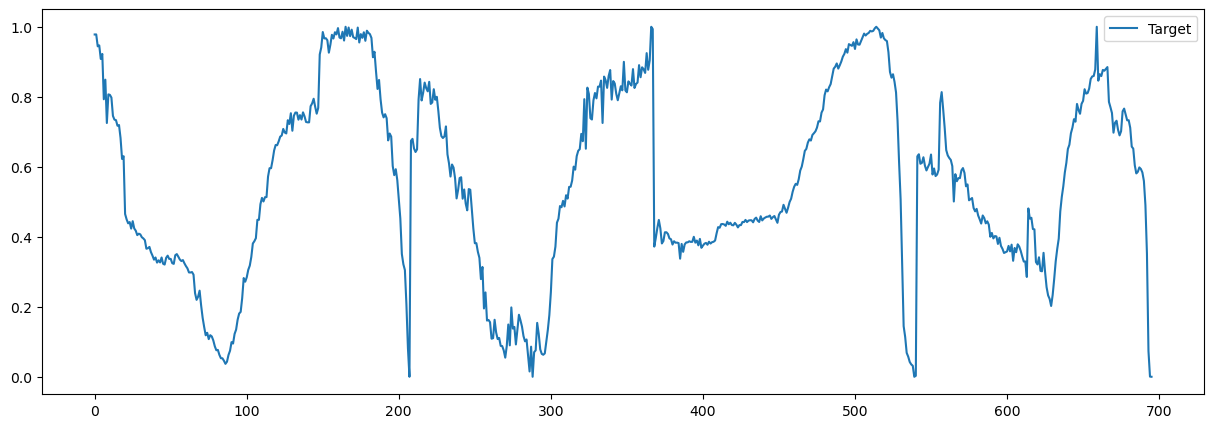

In [22]:
joined_df.plot(y='Target', figsize=(15, 5))

## LSTM Setup

In [124]:
main_df = encoded_main_dfs[list(encoded_main_dfs.keys())[0]]
ml = resources.LSTM_Model(feature_df=joined_df.iloc[:541],
                          target='Target',
                          tb=True,
                          tb_logdir='encoded_input',
                          params={'seq_len': 30,
                                  'epochs': 2000,
                                  'no_nodes': 20, #180,
                                  'batch_size': 50,
                                  'no_layers': 1, #5,
                                  'no_dense': 1,
                                  'dropout': 0.1,
                                  'loss': 'mse',
                                  'callbacks': [tf.keras.callbacks.EarlyStopping(
                                                              monitor='val_loss',
                                                              patience=150,
                                                              mode='min',
                                                              start_from_epoch= 100,
                                                  ),]
                                  },
                        #   random_state=10,
                          # shuffle=False,
)

Overlapping sections between exps not removed!
Overlapping sections between exps not removed!


In [125]:
ml.model.callbacks.append(
    tf.keras.callbacks.ModelCheckpoint(
        filepath=ml._run_name + f'{ml._run_name.split(ml.tb_log_dir)[-1]}.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_weights_only=True,
    )
)

In [126]:
ml.fit(validation_split=0.33, verbose=0)

-----------------------------------------------------------------
LSTM-WLEN-30-E-2000-B-50-L-[20 20]-D-0.1-20230612-155550


Training:   0%|           0/2000 ETA: ?s,  ?epochs/s

In [127]:
ml.model.model_.load_weights(
    ml._run_name + f'{ml._run_name.split(ml.tb_log_dir)[-1]}.h5',
)
# ml.model.model_.load_weights('/mnt/c/Users/tomje/OneDrive - Cardiff University/Documents/PHD/AE/Tensorboard/LSTM/autoe_encoder_test/LSTM-WLEN-15-E-1000-B-50-L-[64 64 64 64]-D-0.1-20230530-105521/LSTM-WLEN-15-E-1000-B-50-L-[64 64 64 64]-D-0.1-20230530-105521.h5')

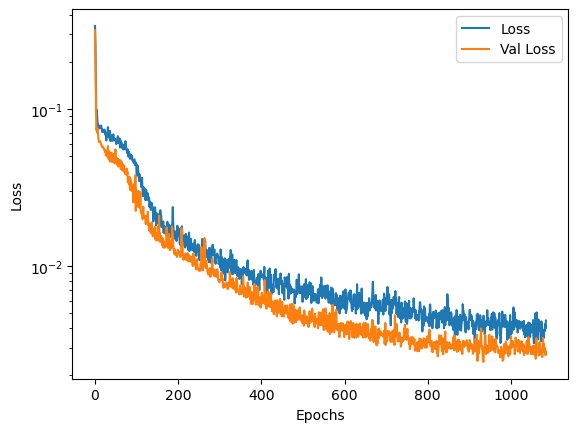

In [128]:
fig, ax = ml.loss_plot()
ax.set_yscale('log')

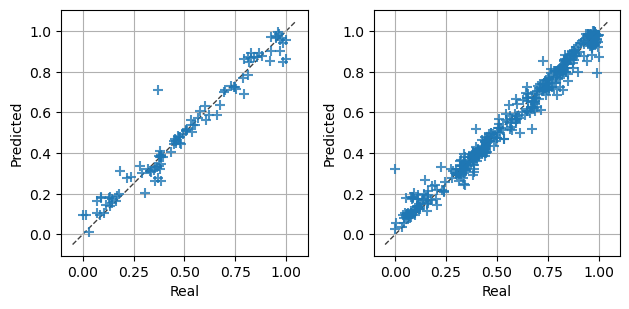

In [129]:
def pred_real_plot(y, y_pred, ax):
    ax.scatter(y, y_pred, marker='+', alpha=0.8, s=50)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]

    ax.set_axisbelow(True)
    ax.grid()
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0, linewidth=1)
    ax.set_aspect('equal')
    ax.set_xlabel('Real')
    ax.set_ylabel('Predicted')
    return ax

fig, ax = plt.subplots(1, 2)
ax[0] = pred_real_plot(ml.val_data[1], ml.model.predict(ml.val_data[0], verbose=0), ax[0])
ax[1] = pred_real_plot(ml.train_data[1], ml.model.predict(ml.train_data[0], verbose=0), ax[1])
fig.tight_layout()

In [130]:
print('TRAINING DATA')
_ = ml.score(X=ml.train_data[0],
              y=ml.train_data[1],
              plot_fig=False,
              )
print('\nVALIDATION DATA')
_ = ml.score(plot_fig=False)

TRAINING DATA
-----------------------------------------------------------------
Validation Scores:
-----------------------------------------------------------------
MAE = 31.090 um
MSE = 1918.237 um^2
R^2 = 0.977

VALIDATION DATA
-----------------------------------------------------------------
Validation Scores:
-----------------------------------------------------------------
MAE = 38.308 um
MSE = 3402.379 um^2
R^2 = 0.958


/home/tomje/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


-----------------------------------------------------------------
Validation Scores:
-----------------------------------------------------------------
MAE = 74.498 um
MSE = 20289.898 um^2
R^2 = 0.718


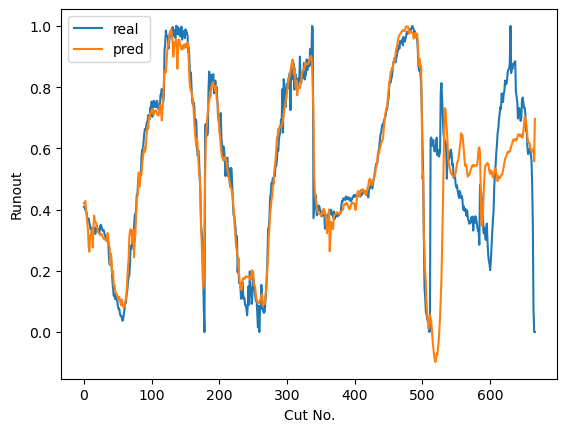

In [131]:
all_x=joined_df.iloc[:, :-1]
all_y=joined_df.iloc[:, -1] 

all_x= ml.scaler.transform(all_x)
all_data = np.column_stack([all_x, all_y])

all_data = ml.sequence_data(all_data)
all_data = pd.DataFrame(all_data , columns=['features', 'target'])

all_x= []
all_y= []
for X, y in all_data .values:
    all_x.append(X)
    all_y.append(y)
all_x= np.array(all_x)
all_y= np.array(all_y)
all_data = [all_x, all_y]

all_pred = ml.model.predict(all_data[0], verbose=0)
fig, ax = plt.subplots()
ax.plot(all_data[1], label='real')
ax.plot(all_pred, label='pred')
ax.legend()
ax.set_xlabel('Cut No.')
ax.set_ylabel(TARGET);
ml.score(X=all_data[0], y=all_data[1], plot_fig=False);

## Transfer Learning

In [132]:
# tr_split = 100

# main_df = encoded_main_dfs[list(encoded_main_dfs.keys())[1]]
# ml_2 = resources.LSTM_Model(feature_df=main_df.iloc[:tr_split],
#                           target='Target',
#                           tb=True,
#                           tb_logdir='encoded_input',
#                           params={'seq_len': 50,
#                                   'epochs': 2000,
#                                   'no_nodes': 180,
#                                   'batch_size': 50,
#                                   'no_layers': 5,
#                                   'no_dense': 2,
#                                   'dropout': 0.1,
#                                   'loss': 'mse',
#                                   'callbacks': [tf.keras.callbacks.EarlyStopping(
#                                                               monitor='val_loss',
#                                                               patience=150,
#                                                               mode='min',
#                                                               start_from_epoch= 100,
#                                                   ),]
#                                   },
#                           # random_state=1,
#                         #   shuffle=False,
# )

In [133]:
ml_2.model.callbacks.append(
    tf.keras.callbacks.ModelCheckpoint(
        filepath=ml_2._run_name + f'{ml_2._run_name.split(ml_2.tb_log_dir)[-1]}.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_weights_only=True,
    )
)

NameError: name 'ml_2' is not defined

In [ ]:
ml_2.model.initialize(X=ml_2.train_data[0], y=ml_2.train_data[1]);

In [ ]:
ml_2.model.model_.load_weights(
    ml._run_name + f'{ml._run_name.split(ml.tb_log_dir)[-1]}.h5',
)

In [ ]:
ml_2.fit(validation_split=0.1, verbose=0)

In [ ]:
ml_2.model.model_.load_weights(
    ml_2._run_name + f'{ml_2._run_name.split(ml_2.tb_log_dir)[-1]}.h5',
)

In [ ]:
fig, ax = ml_2.loss_plot()
ax.set_yscale('log')

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0] = pred_real_plot(ml_2.val_data[1], ml_2.model.predict(ml_2.val_data[0], verbose=0), ax[0])
ax[1] = pred_real_plot(ml_2.train_data[1], ml_2.model.predict(ml_2.train_data[0], verbose=0), ax[1])
fig.tight_layout()

In [ ]:
print('TRAINING DATA')
_ = ml_2.score(X=ml_2.train_data[0],
              y=ml_2.train_data[1],
              plot_fig=False,
              )
print('\nVALIDATION DATA')
_ = ml_2.score(plot_fig=False)

In [ ]:
rest_X = main_df.iloc[tr_split-30:, :-1]
rest_Y = main_df.iloc[tr_split-30:, -1] 

rest_X = ml_2.scaler.transform(rest_X)
rest_data = np.column_stack([rest_X, rest_Y])

rest_data = ml_2.sequence_data(rest_data)
rest_data = pd.DataFrame(rest_data, columns=['features', 'target'])

rest_X = []
rest_Y = []
for X, y in rest_data.values:
    rest_X.append(X)
    rest_Y.append(y)
rest_X = np.array(rest_X)
rest_Y = np.array(rest_Y)
rest_data = [rest_X, rest_Y]

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0] = pred_real_plot(ml_2.train_data[1], ml_2.model.predict(ml_2.train_data[0], verbose=0), ax[0])
ax[1] = pred_real_plot(ml_2.val_data[1], ml_2.model.predict(ml_2.val_data[0], verbose=0), ax[1])
ax[2] = pred_real_plot(rest_data[1], ml_2.model.predict(rest_data[0], verbose=0), ax[2])
fig.tight_layout()
ml_2.score(X=rest_data[0], y=rest_data[1], plot_fig=False);


In [ ]:
all_x= main_df.iloc[:, :-1]
all_y= main_df.iloc[:, -1] 

all_x= ml_2.scaler.transform(all_x)
all_data = np.column_stack([all_x, all_y])

all_data = ml_2.sequence_data(all_data)
all_data = pd.DataFrame(all_data , columns=['features', 'target'])

all_x= []
all_y= []
for X, y in all_data .values:
    all_x.append(X)
    all_y.append(y)
all_x= np.array(all_x)
all_y= np.array(all_y)
all_data = [all_x, all_y]

all_pred = ml_2.model.predict(all_data[0], verbose=0)
fig, ax = plt.subplots()
ax.plot(all_data[1], label='real')
ax.plot(all_pred, label='pred')
ax.legend()